In [1]:
import numpy as np
import scipy.stats as sstats
from matplotlib import pyplot as plt

In [2]:
plt.xkcd()
plt.rcParams['figure.figsize'] = (20,10)

In [3]:
import cbayes.sample as samp
import cbayes.distributions as dist
import cbayes.solve as solve

In [4]:
def QoI_fun(lam):
    return np.power(lam, 5).reshape(-1, 1)

## Consistent Bayes

In [5]:
N = int(5E3)
input_dim = 1
output_dim = input_dim
s_set = samp.sample_set(size=(N, input_dim))
for i in range(input_dim):# define prior distribution
    s_set.set_dist('uni', {'loc':-1, 'scale':2}, 0) # uniform
#     s_set.set_dist('norm', {'loc':0, 'scale':0.5}, 0) # normal distribution 
s_set.generate_samples()
p_set = samp.map_samples_and_create_problem(s_set, QoI_fun)

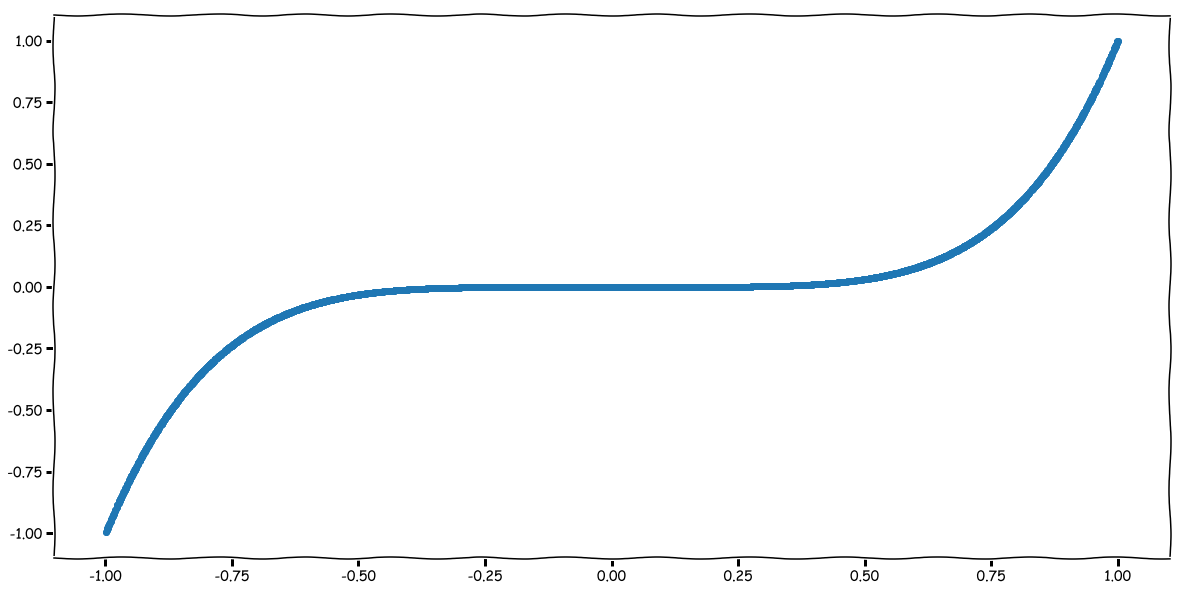

In [6]:
plt.scatter(p_set.input.samples[:], p_set.output.samples[:])
plt.show()

In [7]:
sd = 0.1
lo = 0.25
p_set.set_observed_dist('norm', dim=0, kwds={'loc':lo, 'scale': sd})
# FIX THE BUG WHERE YOU CANNOT OVERWRITE THIS... (didn't I already do this?... maybe just forgot to apply it to the observed dist part)

In [8]:
# p_set.compute_pushforward_dist(method='sk',kwds={'kernel': 'gaussian', 'bandwidth':0.1})

In [9]:
p_set.compute_pushforward_dist(method='scipy')

In [10]:
# CREATE SHORT-VERSION FUNCTION HANDLES (for convenience)
pf = p_set.pushforward_dist
pr = p_set.prior_dist
ob = p_set.observed_dist

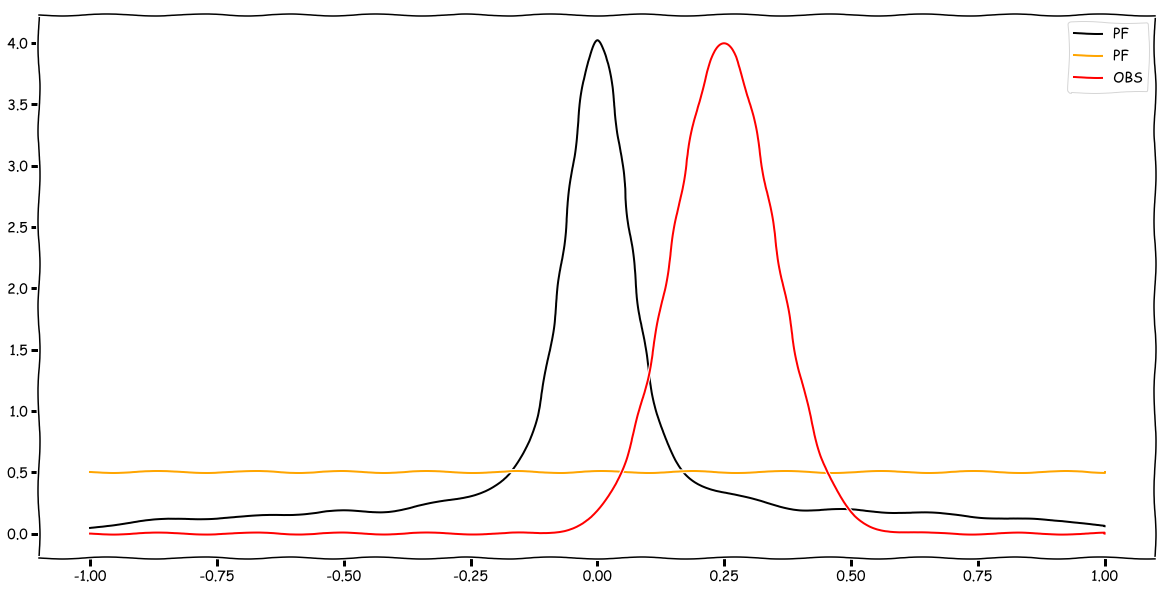

In [36]:
x = np.linspace(-1.0,1.0,1000)
plt.plot(x,pf.pdf(x), label='PF', c='k')
plt.plot(x,pr.pdf(x), label='PF', c = 'orange')
plt.plot(x,ob.pdf(x), label='OBS', c='r')
plt.legend()
plt.show()

In [12]:
# Solve CBayes 
p_set.set_ratio()
solve.problem(p_set)

## Statistical Bayes

In [15]:
L = dist.parametric_dist(output_dim)
for i in range(output_dim):
    L.set_dist(i, 'norm',{'loc':lo, 'scale':sd })


In [16]:
likelihood = L.pdf(p_set.output.samples)
prior = p_set.input.dist.pdf(p_set.input.samples)

In [17]:
import scipy.integrate as integrate
def statBayesPost(x):
    y = ob.pdf(QoI_fun(x))
    return y

intConst=integrate.quad(statBayesPost,-1,1)

In [18]:
intConst

(0.8670861016200645, 5.186132031226353e-13)

In [34]:
indS = solve.perform_accept_reject(p_set.output.samples, likelihood)
indC = solve.perform_accept_reject(p_set.output.samples, p_set.ratio)
print("ACCEPTED:", "S:", len(indS), "| B:", len(indC), " OF", N)

ACCEPTED: S: 543 | B: 367  OF 5000


In [22]:
# SMOOTH POSTERIORS FOR PLOTTING
cb_ps_den = dist.gkde(p_set.input.samples[indC])
sb_ps_den = dist.gkde(p_set.input.samples[indS])
# SMOOTH PUSH-FORWARDS OF POSTERIORS FOR PLOTTING
cb_pf_den = dist.gkde(p_set.output.samples[indC])
sb_pf_den = dist.gkde(p_set.output.samples[indS])

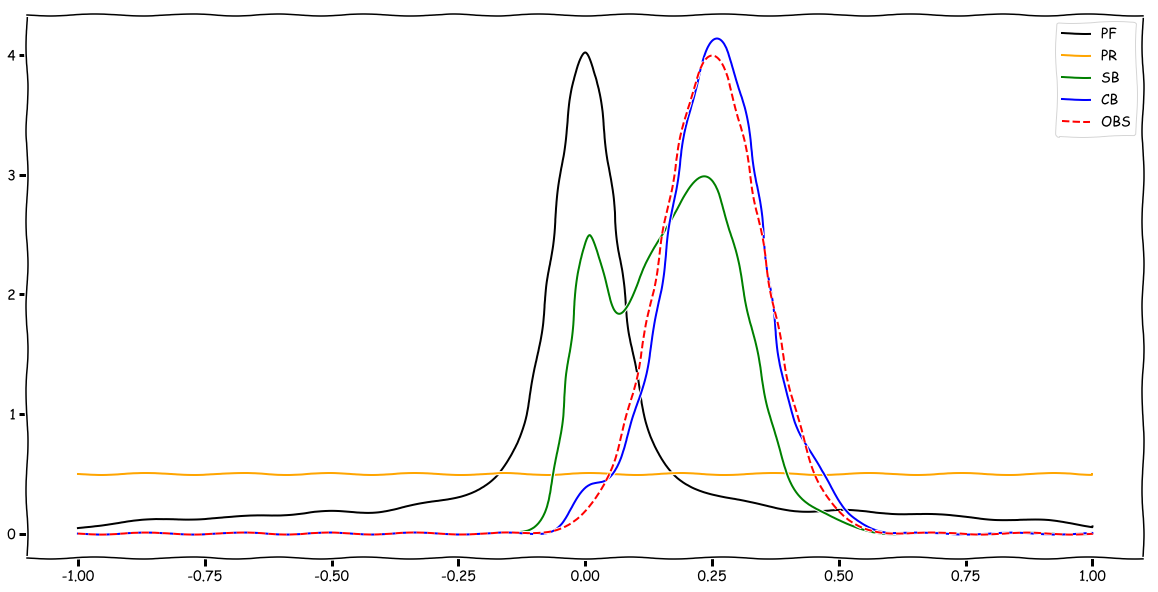

In [26]:
# plt.plot(x, cb_pf_den.pdf(x), c='b', label='CB sol')
# plt.plot(x, sb_pf_den.pdf(x), c='k', label='SB sol')
plt.plot(x, pf.pdf(x), c='k', label='PF')
plt.plot(x, pr.pdf(x),  c='orange', label='PR')
plt.plot(x, sb_pf_den.pdf(x),  c='g', label='SB')
plt.plot(x, cb_pf_den.pdf(x),  c='b', label='CB')
plt.plot(x, ob.pdf(x),  c='r', ls='--', label='OBS')
# plt.ylim([0,6])
plt.legend()
plt.show()